# <center>
#  Модель предсказания предела текучести расплава (ПТР) по LSTM
<img src = https://www.sibur.ru/img/logo.png>
</center>
<p>автор: Данилов К.В.</p>
2017, февраль

### Import libraries

In [1]:
# importing libraries
import sys
import json
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from tqdm import tqdm
import math
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', 100)

/home/konstantin/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tensorflow: 1.4.1
keras: 2.1.3


Using TensorFlow backend.


### Loading dataset

In [2]:
with open('config.json', 'r') as file:
    config = json.load(file)

DATA_FILE = 'mfi_granules_processed.csv'

In [3]:
MODEL_ID = 'sbt_breakage.v.4.0'

data = pd.read_csv(os.path.join(config['DATA_PATH'], DATA_FILE), sep='\t', 
                   index_col=['ts'], parse_dates=['ts'], dayfirst=True)

In [4]:
data.head()

,mfi,mfi_err,prop_mode_2,prop_mode_3,prop_mode_4,prop_mode_8,prop_mode_9,prop_mode_10,prop_mode_11,prop_mode_15,prop_mode_16,prop_mode_19,prop_mode_20,mfi_1,mfi_err_1,mfi_2,mfi_err_2,mfi_3,mfi_err_3,mfi_4,mfi_err_4,mfi_5,mfi_err_5,mfi_6,mfi_err_6,mfi_7,mfi_err_7,mfi_8,mfi_err_8,mfi_9,mfi_err_9,mfi_10,mfi_err_10,df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,mfi_med
ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-02-01 02:00:00,3.00,0.21,32.12,30.3,52.63,4.13,4.0,116.04,116.04,16664.34,61.39,2.13,751.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01 04:00:00,2.95,0.21,32.11,30.3,52.63,4.13,4.0,116.22,116.22,16708.93,61.39,2.07,751.37,3.00,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01 06:00:00,2.98,0.21,32.47,30.3,52.63,4.30,4.0,118.01,118.01,16840.06,61.28,2.07,751.37,2.95,0.21,3.00,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01 08:00:00,2.90,0.20,32.37,30.3,52.63,4.30,4.0,118.05,118.05,16829.42,61.19,2.07,751.37,2.98,0.21,2.95,0.21,3.00,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,-0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01 10:00:00,2.97,0.21,32.26,30.3,52.63,4.35,4.0,118.11,118.11,16812.71,61.74,2.09,751.37,2.90,0.20,2.98,0.21,2.95,0.21,3.0,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.08,0.03,-0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Our variables
<p><b>2</b> - расход по жидкому пропилену </p>
<p><b>3</b> - ампераж мешалки</p>
<p><b>4</b> - уровень в реакторе</p>
<p><b>8</b> - H2/C3</p>
<p><b>9</b> - Расчетное соотношение Al / Mg</p>
<p><b>10</b> - расход Al/Si</p>
<p><b>11</b> - расход Al/Si</p>
<p><b>15</b> - активность катализатора</p>
<p><b>16</b> - температура в зоне 1</p>
<p><b>19</b> - водород</p>
<p><b>20</b> - отходящие газы</p>

In [5]:
dataset = data['mfi'].reset_index().drop('ts',axis=1).values
dataset = dataset.astype('float32')
dataset

array([[3.  ],
       [2.95],
       [2.98],
       ...,
       [2.83],
       [2.91],
       [2.9 ]], dtype=float32)

In [6]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Normalize the dataset

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
dataset

array([[0.4351145 ],
       [0.39694655],
       [0.41984737],
       ...,
       [0.3053435 ],
       [0.36641228],
       [0.3587786 ]], dtype=float32)

###  Split into train and test sets

In [9]:
may_day = '2017-07-01 00:00:00'
index_traintest_split = data.index.get_loc(may_day)
train_size = index_traintest_split
test_size = len(dataset) - train_size
train, test = dataset[0:index_traintest_split,:], dataset[train_size:len(dataset),:]

### Reshape into X=t and Y=t+1

In [10]:
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

### Reshape input to be [samples, time steps, features]

In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Create and fit the LSTM network

In [45]:
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(10, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(10, input_shape=(1, look_back), return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
1937/1937 [==============================] - 15s 8ms/step - loss: 0.0126
Epoch 2/100
1937/1937 [==============================] - 13s 7ms/step - loss: 0.0057
Epoch 3/100
1937/1937 [==============================] - 13s 7ms/step - loss: 0.0052
Epoch 4/100
1937/1937 [==============================] - 13s 7ms/step - loss: 0.0051
Epoch 5/100
1937/1937 [==============================] - 13s 7ms/step - loss: 0.0050
Epoch 6/100
1937/1937 [==============================] - 13s 7ms/step - loss: 0.0050
Epoch 7/100
1937/1937 [==============================] - 13s 7ms/step - loss: 0.0050
Epoch 8/100
1937/1937 [==============================] - 13s 7ms/step - loss: 0.0050
Epoch 9/100
1937/1937 [==============================] - 13s 7ms/step - loss: 0.0049
Epoch 10/100
1937/1937 [==============================] - 14s 7ms/step - loss: 0.0050
Epoch 11/100
1937/1937 [==============================] - 13s 7ms/step - loss: 0.0048
Epoch 12/100
1937/1937 [==============================] - 13s 7

### Make predictions

In [46]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

### Invert predictions

In [47]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

### Calculate root mean squared error and r^2

In [48]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
r2_val = r2_score(testY[0], testPredict[:,0])
'r2_score: {:.2%}'.format(r2_val)

Train Score: 0.09 RMSE
Test Score: 0.08 RMSE


'r2_score: 66.50%'

### Shift train and test predictions for plotting

In [50]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

### Plot predictions

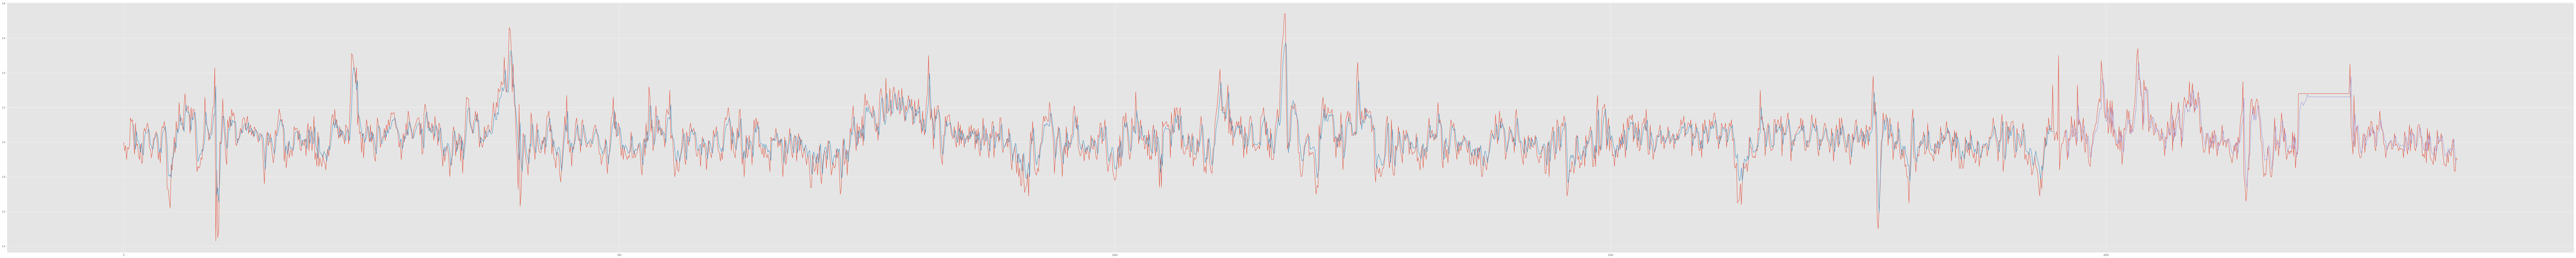

In [51]:
plt.style.use('ggplot')
plt.figure(figsize=(200,20))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()